<a href="https://colab.research.google.com/github/mtermor/NTIC_DeepLearning/blob/main/RNN/Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning_solutions_solutions/blob/main/class/RNN/Seq2seq.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning_solutions_solutions/blob/main/class/RNN/Seq2seq.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

In this example, we train a model to learn to add two numbers, provided as strings.

**Example:**

- Input: "535+61"
- Output: "596"

[Notebook from Keras Tutorial](https://keras.io/examples/nlp/addition_rnn/)

## Seq to seq model

Keras provides the `return_state` argument to the LSTM layer that will provide access to the hidden state output (state_h) and the cell state (state_c). Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [2]:
(timesteps, features, output_timesteps) = (10, 5, 12)

# Encoder
encoder_input = tf.keras.Input(shape=(timesteps, features),
                               name='encoder_input')

# Return states in addition to output
_, state_h, state_c = layers.LSTM(64, return_state=True,
                                       name="encoder")(encoder_input)
# Enncoded vector
encoder_state = [state_h, state_c]

# Decoder
decoder_input = tf.keras.Input(shape=(output_timesteps, 1),
                               name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, return_sequences=True,
                             name="decoder")(decoder_input,
                                             initial_state=encoder_state)
output = layers.TimeDistributed(layers.Dense(5))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 10, 5)]              0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 12, 1)]              0         []                            
                                                                                                  
 encoder (LSTM)              [(None, 64),                 17920     ['encoder_input[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                              

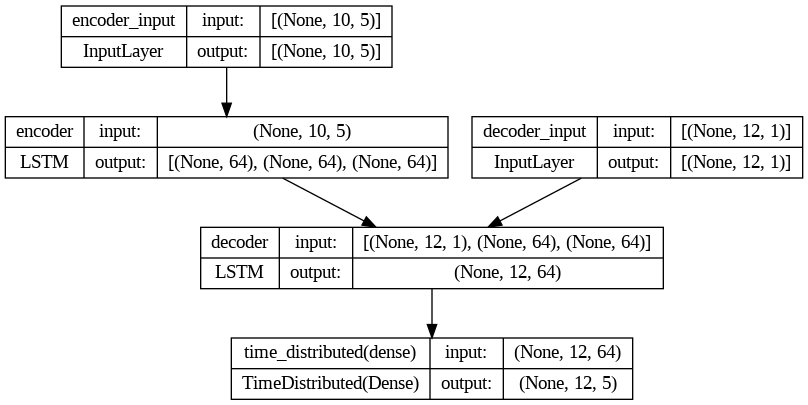

In [3]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [4]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz, max_len):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.max_len = max_len

        ##________ LSTM layer in Encoder ------- ##
        self.lstm_layer = tf.keras.layers.LSTM(self.enc_units,
                                               return_sequences=True,
                                               return_state=True)

    def call(self, encoder_input):
        _, state_h, state_c = self.lstm_layer(encoder_input)
        # Enncoded vector
        encoder_state = [state_h, state_c]
        return encoder_state

class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz, max_len):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.max_len = max_len
        self.decoder_input = tf.zeros((self.batch_sz, self.max_len, 1))

        self.lstm_layer = tf.keras.layers.LSTM(self.dec_units,
                                               return_sequences=True)

    def call(self, encoder_state):
        x = self.lstm_layer(self.decoder_input, initial_state=encoder_state)
        output = layers.TimeDistributed(layers.Dense(5))(x)
        return output

encoder_input = tf.keras.Input(shape=(10, 10),
                               name='encoder_input')
encoder = Encoder(10, 10, 5)
encoder_state = encoder(encoder_input)

decoder= Decoder(10, 10, 5)
outputs = decoder(encoder_state)

model = keras.Model(encoder_input, outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 10, 10)]             0         []                            
                                                                                                  
 encoder (Encoder)           [(None, 10),                 840       ['encoder_input[0][0]']       
                              (None, 10)]                                                         
                                                                                                  
 decoder (Decoder)           (10, 5, 5)                   480       ['encoder[0][0]',             
                                                                     'encoder[0][1]']             
                                                                                            

You can also use [layers.RepeatVector](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)

In [5]:
model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
model.add(layers.LSTM(128, input_shape=(timesteps, features)))
model.add(layers.RepeatVector(output_timesteps))
model.add(layers.LSTM(128, return_sequences=True))
# Apply a dense layer to the every temporal slice of an input
model.add(layers.Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 repeat_vector (RepeatVecto  (None, 12, 128)           0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 12, 128)           131584    
                                                                 
 dense_1 (Dense)             (None, 12, 5)             645       
                                                                 
Total params: 200837 (784.52 KB)
Trainable params: 200837 (784.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


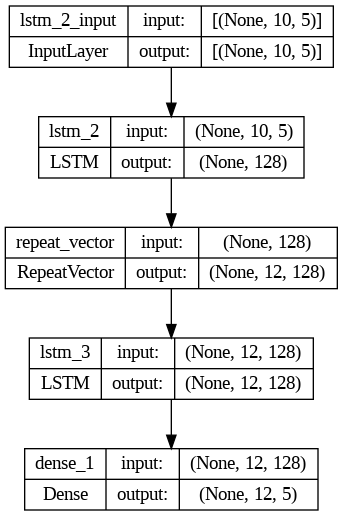

In [6]:
plot_model(model, show_shapes=True)

## Generate the data


In [7]:
max_digits = 3
max_int = 10**max_digits - 1
max_len = max_digits + 1 + max_digits
out_max_len = len(str(max_int + max_int))
print('max_digits : {0}, max_int: {1}, max_len: {2}, out_max_len: {3}'.format(
    max_digits, max_int, max_len, out_max_len))
print('max input length from {0}+{0} is {1}'.format(max_int,max_len))
print('max sum: {0}+{0}={1}'.format(max_int,max_int+max_int))

max_digits : 3, max_int: 999, max_len: 7, out_max_len: 4
max input length from 999+999 is 7
max sum: 999+999=1998


In [8]:
def generate_sample(max_len, max_int, out_max_len):
    a, b = np.random.randint(max_int, size=2)
    sentence = '{0}+{1}'.format(a, b)
    sentence = sentence + ' ' * (max_len - len(sentence))  # padding
    result = str(a + b)
    result = result + ' ' * (out_max_len - len(result))  # padding
    return sentence, result


sentences = []
results = []
seen = set()
print("Generating data...")
while len(sentences) < 50000:
    sentence, result = generate_sample(max_len, max_int, out_max_len)
    if sentence in seen:
        continue
    seen.add(sentence)
    sentences.append(sentence)
    results.append(result)
print("Total sentences:", len(sentences))
print('Some examples:', list(zip(sentences[:3], results[:3])))

Generating data...
Total sentences: 50000
Some examples: [('423+49 ', '472 '), ('659+215', '874 '), ('967+696', '1663')]


## Vectorize the data


In [9]:
chars = "0123456789+ "

char_indices = {c:i for i, c in enumerate(sorted(chars))}
print('char_indices', char_indices)
indices_char = {i:c for c,i in char_indices.items()}
print('indices_char', indices_char)

def vectorize_sentence(sentence, char_indices):
    x = np.zeros((len(sentence), len(char_indices)))
    for i, c in enumerate(list(sentence)):
        x[i, char_indices[c]] = 1
    return x

x = vectorize_sentence('13+11', char_indices)

print('sentence: 13+11')
print('vectorize_sentence inds:', x.argmax(-1))
print('vectorize_sentence :', x)

char_indices {' ': 0, '+': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}
indices_char {0: ' ', 1: '+', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9'}
sentence: 13+11
vectorize_sentence inds: [3 5 1 3 3]
vectorize_sentence : [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
def vec_to_sentence(x, indices_char):
    return "".join(indices_char[i] for i in x)

def mat_to_sentence(x, indices_char):
    x = x.argmax(axis=-1)
    return "".join(indices_char[i] for i in x)

mat_to_sentence(x, indices_char)

'13+11'

In [11]:
print("Vectorization...")
x = np.zeros((len(sentences), max_len, len(chars)), dtype=bool)
y = np.zeros((len(sentences), out_max_len, len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    x[i] = vectorize_sentence(sentence, char_indices)
for i, sentence in enumerate(results):
    y[i] = vectorize_sentence(sentence, char_indices)

# Explicitly set apart 10% for validation data that we never train over.
val_split = int(0.8 * len(x))
test_split = int(0.9 * len(x))

(x_train, y_train) = x[:val_split], y[:val_split]
(x_val, y_val) = x[val_split:test_split], y[val_split:test_split]
(x_test, y_test) = x[test_split:], y[test_split:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

print("Test Data:")
print(x_test.shape)
print(y_test.shape)

Vectorization...
Training Data:
(40000, 7, 12)
(40000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Test Data:
(5000, 7, 12)
(5000, 4, 12)


In [12]:
# (Tamaño data, tamaño sample (7=7 digitos), tamaño diccionario)

## Build the model


In [13]:
encoded_dim = 16 #más pequeño, menos información a almacenar

In [14]:
# Encoder
encoder_input = tf.keras.Input(
    shape=(max_len, len(chars)), name='encoder_input')

# Return states in addition to output
_, state_h, state_c = layers.LSTM(encoded_dim, return_state=True, name="encoder")(
    encoder_input
)

# Enncoded vector
encoder_state = [state_h, state_c]

# Decoder
decoder_input = tf.keras.Input(
    shape=(out_max_len, 1), name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(encoded_dim, return_sequences=True, name="decoder")(
    decoder_input, initial_state=encoder_state
)
output = layers.TimeDistributed(layers.Dense(len(chars), activation='softmax'))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 7, 12)]              0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 4, 1)]               0         []                            
                                                                                                  
 encoder (LSTM)              [(None, 16),                 1856      ['encoder_input[0][0]']       
                              (None, 16),                                                         
                              (None, 16)]                                                         
                                                                                            

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
## The inputs of the decoder are zeros
decoder_input_data = np.zeros((len(x_train), out_max_len, 1))
decoder_input_data_val = np.zeros((len(x_val), out_max_len, 1))

In [17]:
epochs=30
batch_size=64

for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        [x_train, decoder_input_data],
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=([x_val, decoder_input_data_val], y_val),
    )

    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], 1*y_val[ind]
        preds = np.argmax(model.predict([rowx, decoder_input_data_val[[0],:]]), axis=-1).flatten()
        q = mat_to_sentence(rowx[0], indices_char)
        correct = mat_to_sentence(rowy, indices_char)
        guess = vec_to_sentence(preds, indices_char)
        print()
        print("Input: ", q, "Correct output", correct)
        print('Prediction')
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)


Iteration 1
1/1 [==============================] - 1s 713ms/step

Input:  710+203 Correct output 913 
Prediction
☒ 113 
1/1 [==============================] - 0s 32ms/step

Input:  748+821 Correct output 1569
Prediction
☒ 110 
1/1 [==============================] - 0s 20ms/step

Input:  511+973 Correct output 1484
Prediction
☒ 113 
1/1 [==============================] - 0s 20ms/step

Input:  479+110 Correct output 589 
Prediction
☒ 112 
1/1 [==============================] - 0s 21ms/step

Input:  430+518 Correct output 948 
Prediction
☒ 113 

Iteration 2
1/1 [==============================] - 0s 23ms/step

Input:  162+584 Correct output 746 
Prediction
☒ 101 
1/1 [==============================] - 0s 21ms/step

Input:  643+307 Correct output 950 
Prediction
☒ 101 
1/1 [==============================] - 0s 20ms/step

Input:  391+127 Correct output 518 
Prediction
☒ 109 
1/1 [==============================] - 0s 21ms/step

Input:  690+229 Correct output 919 
Prediction
☒ 101 
1/1 [=====

In [18]:
decoder_input_data_test = np.zeros((len(x_test), out_max_len, 1))

results = model.evaluate([x_test, decoder_input_data_test], y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

157/157 [==============================] - 1s 4ms/step - loss: 1.3665 - accuracy: 0.4771
Test Loss: 1.3665410280227661
Test Accuracy: 0.4770500063896179


### Question 1: Find a model with test `accuracy> 0.9`


Study the influence of the encoded vector dimension

In [19]:
encoded_dim = 256

In [20]:
## Encoder
encoder_input = tf.keras.Input(
    shape=(max_len, len(chars)), name='encoder_input')

# Return states in addition to output
_, state_h, state_c = layers.LSTM(encoded_dim, return_state=True, name="encoder")(
    encoder_input
)

# Enncoded vector
encoder_state = [state_h, state_c]


# Decoder
decoder_input = tf.keras.Input(
    shape=(out_max_len, 1), name='decoder_input')

decoder_output = layers.LSTM(encoded_dim, return_sequences=True, name="decoder")(
    decoder_input, initial_state=encoder_state
)
output = layers.TimeDistributed(layers.Dense(len(chars), activation='softmax'))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 7, 12)]              0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 4, 1)]               0         []                            
                                                                                                  
 encoder (LSTM)              [(None, 256),                275456    ['encoder_input[0][0]']       
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [21]:
## The inputs of the decoder are zeros
decoder_input_data = np.zeros((len(x_train), out_max_len, 1))
decoder_input_data_val = np.zeros((len(x_val), out_max_len, 1))


In [22]:
epochs=30
batch_size=64

for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        [x_train, decoder_input_data],
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=([x_val, decoder_input_data_val], y_val),
    )

    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], 1*y_val[ind]
        preds = np.argmax(model.predict([rowx, decoder_input_data_val[[0],:]]), axis=-1).flatten()
        q = mat_to_sentence(rowx[0], indices_char)
        correct = mat_to_sentence(rowy, indices_char)
        guess = vec_to_sentence(preds, indices_char)
        print()
        print("Input: ", q, "Correct output", correct)
        print('Prediction')
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)


Iteration 1
1/1 [==============================] - 1s 685ms/step

Input:  5+629   Correct output 634 
Prediction
☒ 337 
1/1 [==============================] - 0s 24ms/step

Input:  18+202  Correct output 220 
Prediction
☒ 277 
1/1 [==============================] - 0s 24ms/step

Input:  649+144 Correct output 793 
Prediction
☒ 807 
1/1 [==============================] - 0s 25ms/step

Input:  931+955 Correct output 1886
Prediction
☒ 1755
1/1 [==============================] - 0s 23ms/step

Input:  961+594 Correct output 1555
Prediction
☒ 1527

Iteration 2
1/1 [==============================] - 0s 37ms/step

Input:  314+665 Correct output 979 
Prediction
☒ 902 
1/1 [==============================] - 0s 34ms/step

Input:  9+107   Correct output 116 
Prediction
☒ 16  
1/1 [==============================] - 0s 38ms/step

Input:  474+33  Correct output 507 
Prediction
☒ 596 
1/1 [==============================] - 0s 47ms/step

Input:  934+767 Correct output 1701
Prediction
☒ 1751
1/1 [=====

In [23]:
decoder_input_data_test = np.zeros((len(x_test), out_max_len, 1))
results = model.evaluate([x_test, decoder_input_data_test], y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

157/157 [==============================] - 1s 4ms/step - loss: 0.0211 - accuracy: 0.9929
Test Loss: 0.02106378972530365
Test Accuracy: 0.9928500056266785


## Practice

Create a similar model for integer division, rounded to 3 decimals:
```python
'999/7' -> '142.714'
'3/4' -> '0.75'
'1/3' -> '0.333'
```

In [24]:
max_digits = 3
max_int = 10**max_digits - 1
max_len = 7#
out_max_len = 7#
print('max_digits : {0}, max_int: {1}, max_len: {2}, out_max_len: {3}'.format(
    max_digits, max_int, max_len, out_max_len))

max_digits : 3, max_int: 999, max_len: 7, out_max_len: 7


In [25]:
np.random.randint(max_int)

605

In [26]:
def generate_sample(max_len, max_int, out_max_len):
    a = np.random.randint(max_int)
    b = np.random.randint(1, max_int) # zero division
    sentence = '{0}/{1}'.format(a, b)
    sentence = sentence + ' ' * (max_len - len(sentence))  # padding
    result = str(np.round(a / b, 3))
    result = result + ' ' * (out_max_len - len(result))  # padding
    return sentence, result


sentences = []
results = []
seen = set()
print("Generating data...")
while len(sentences) < 100000:
    sentence, result = generate_sample(max_len, max_int, out_max_len)
    if sentence in seen:
        continue
    seen.add(sentence)
    sentences.append(sentence)
    results.append(result)
print("Total sentences:", len(sentences))
print('Some examples:', list(zip(sentences[:3], results[:3])))

Generating data...
Total sentences: 100000
Some examples: [('413/721', '0.573  '), ('501/795', '0.63   '), ('354/773', '0.458  ')]


In [27]:
## Data vectorization

chars = "0123456789/. "

char_indices = {c:i for i, c in enumerate(sorted(chars))}
print('char_indices', char_indices)
indices_char = {i:c for c,i in char_indices.items()}
print('indices_char', indices_char)

def vectorize_sentence(sentence, char_indices):
    x = np.zeros((len(sentence), len(char_indices)))
    for i, c in enumerate(list(sentence)):
        x[i, char_indices[c]] = 1
    return x

x = vectorize_sentence('13/11', char_indices)

print('sentence: 13/11')
print('vectorize_sentence inds:', x.argmax(-1))
print('vectorize_sentence :', x)

char_indices {' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12}
indices_char {0: ' ', 1: '.', 2: '/', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9'}
sentence: 13/11
vectorize_sentence inds: [4 6 2 4 4]
vectorize_sentence : [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [28]:
def vec_to_sentence(x, indices_char):
    return "".join(indices_char[i] for i in x)

def mat_to_sentence(x, indices_char):
    x = x.argmax(axis=-1)
    return "".join(indices_char[i] for i in x)

mat_to_sentence(x, indices_char)

'13/11'

In [30]:
print("Vectorization...")
x = np.zeros((len(sentences), max_len, len(chars)), dtype=bool)
y = np.zeros((len(sentences), out_max_len, len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    x[i] = vectorize_sentence(sentence, char_indices)
for i, sentence in enumerate(results):
    y[i] = vectorize_sentence(sentence, char_indices)

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(90000, 7, 13)
(90000, 7, 13)
Validation Data:
(10000, 7, 13)
(10000, 7, 13)


In [31]:
# Encoder
encoder_input = tf.keras.Input(
    shape=(max_len, len(chars)), name='encoder_input')

# Return states in addition to output
output, state_h, state_c = layers.LSTM(256, return_state=True, name="encoder_2")(
    encoder_input
)

# Enncoded vector
encoder_state = [state_h, state_c]

# Decoder
decoder_input = tf.keras.Input(
    shape=(out_max_len, 1), name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(256, return_sequences=True, name="decoder")(
    decoder_input, initial_state=encoder_state
)
output = layers.TimeDistributed(layers.Dense(len(chars), activation='softmax'))(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 7, 13)]              0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 7, 1)]               0         []                            
                                                                                                  
 encoder_2 (LSTM)            [(None, 256),                276480    ['encoder_input[0][0]']       
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
decoder_input_data = np.zeros((len(x_train), out_max_len, 1))
decoder_input_data_val = np.zeros((len(x_val), out_max_len, 1))

In [33]:
epochs=30
batch_size=64

for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        [x_train, decoder_input_data],
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=([x_val, decoder_input_data_val], y_val),
    )

    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], 1*y_val[ind]
        preds = np.argmax(model.predict([rowx, decoder_input_data_val[[0],:]]), axis=-1).flatten()
        q = mat_to_sentence(rowx[0], indices_char)
        correct = mat_to_sentence(rowy, indices_char)
        guess = vec_to_sentence(preds, indices_char)
        print()
        print("Input: ", q, "Correct output", correct)
        print('Prediction')
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)


Iteration 1
1/1 [==============================] - 1s 635ms/step

Input:  986/770 Correct output 1.281  
Prediction
☒ 1.282  
1/1 [==============================] - 0s 26ms/step

Input:  502/653 Correct output 0.769  
Prediction
☒ 0.722  
1/1 [==============================] - 0s 21ms/step

Input:  133/789 Correct output 0.169  
Prediction
☒ 0.232  
1/1 [==============================] - 0s 20ms/step

Input:  753/959 Correct output 0.785  
Prediction
☒ 0.722  
1/1 [==============================] - 0s 20ms/step

Input:  588/308 Correct output 1.909  
Prediction
☒ 1.882  

Iteration 2
1/1 [==============================] - 0s 20ms/step

Input:  128/857 Correct output 0.149  
Prediction
☒ 0.157  
1/1 [==============================] - 0s 21ms/step

Input:  986/454 Correct output 2.172  
Prediction
☒ 2.215  
1/1 [==============================] - 0s 21ms/step

Input:  567/695 Correct output 0.816  
Prediction
☒ 0.855  
1/1 [==============================] - 0s 21ms/step

Input:  633/29  